#  Discrete Non Linear Schödinger (NLS): preliminary experiments

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-NLS">
             Initial value problem: NLS</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Float64-Computations">
             Float64 Computations</a></li>

<li><a href="#Float128-Computations">
             Float128 Computations</a></li> 

</ul>  

- This system has a nonseparable Hamiltonian that can be writen as

$$
H(q,p)=\frac{1}{4} \sum_{i=1}^{N} (q_i+p_i)^2-\sum_{i=2}^{N} (p_{i-1}^2p_i^2+q_{i-1}^2q_i^2-q_{i-1}^2p_i^2-p_{i-1}^2q_i^2+4p_{i-1}q_{i-1}q_i)
$$


- We have considered the next initial values of NLS with $N=5$

\begin{align*}
&(q_1,p_1)=(3,1) \\
&(q_i,p_i)=(0.01,0), \quad i \ne 1
\end{align*}

- Integration interval: $0 \le t \le 3$


- Reference: Explicit symplectic approximation of nonseparable
Hamiltonians: Algorithm and long time performance, Molei Tao, 2016, Phys.Rev.E 94, 043302

## Loading packages

In [1]:
using OrdinaryDiffEq, DiffEqDevTools
using LinearAlgebra, Plots
using Dates,LaTeXStrings
using JLD2, FileIO
using BenchmarkTools
using IRKGaussLegendre

<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [3]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: NLS

In [4]:
include("../ODEProblems/NLS.jl")
include("../ODEProblems/InitialNLS.jl")

t0=0.0
t1=3.0


u064 =InitialNLS(Float64)
tspan64=(t0,t1)
prob64 = ODEProblem(NLSODE!,u064,tspan64)

setprecision(BigFloat, 108);
u0128 =InitialNLS(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NLSODE!,u0128,tspan128);
(typeof(u064),typeof(tspan64),typeof(u0128),typeof(tspan128))

(Vector{Float64}, Tuple{Float64, Float64}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [5]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/NLS_test_sol.jld2" sol

@load "./Data/NLS_test_sol.jld2" sol
test_sol = TestSolution(sol);
sol.destats

u0256 =InitialNLS(BigFloat)
E0=NLSHam(u0256,[])
(Float32(sol.t[end]),Float32(NLSHam(sol.u[end],[])/E0.-1))

(3.0f0, -1.7873105f-33)

<a href="#top">Back to the top</a>

## Float64 Computations

### IRKGL16 (adaptive)

In [6]:
sol1 = solve(prob64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true)
sol1.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  12096
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1512
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          71
Number of rejected steps:                          20

In [7]:
@btime solve(prob64,IRKGL16(), reltol=1e-12, abstol=1e-12, adaptive=true, save_everystep=false);

  2.037 ms (446 allocations: 133.30 KiB)


### IRKGL16-SIMD

In [8]:
sol2 = solve(prob64,IRKGL16(simd=true), reltol=1e-12, abstol=1e-12, adaptive=true)
sol2.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  12432
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1554
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          71
Number of rejected steps:                          20

In [52]:
@btime solve(prob64,IRKGL16(simd=true), reltol=1e-12, abstol=1e-12, adaptive=true, save_everystep=false);

  698.281 μs (427 allocations: 150.17 KiB)


### Vern9 

In [86]:
sol9 =solve(prob64,Vern9(),abstol=1e-15,reltol=1e-15);
sol9.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  10978
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          685
Number of rejected steps:                          1

In [85]:
@btime solve(prob64,Vern9(),abstol=1e-15,reltol=1e-15, save_everystep=false);

  716.823 μs (11034 allocations: 177.67 KiB)


### Some Plots

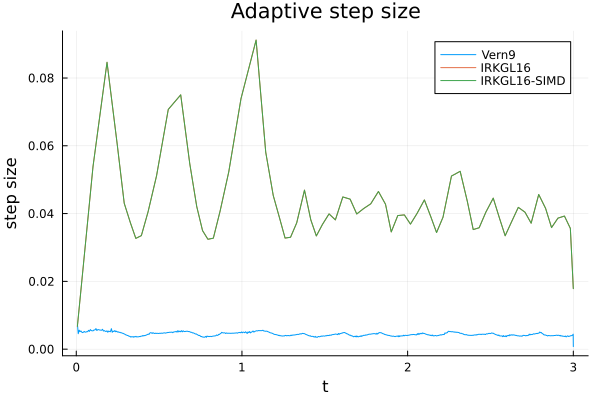

In [87]:
steps9 =sol9.t[2:end]-sol9.t[1:end-1]
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
steps2 =sol2.t[2:end]-sol2.t[1:end-1]
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
plot!(sol9.t[2:end],steps9, label="Vern9")
plot!(sol1.t[2:end],steps1, label="IRKGL16")
plot!(sol2.t[2:end],steps2, label="IRKGL16-SIMD")

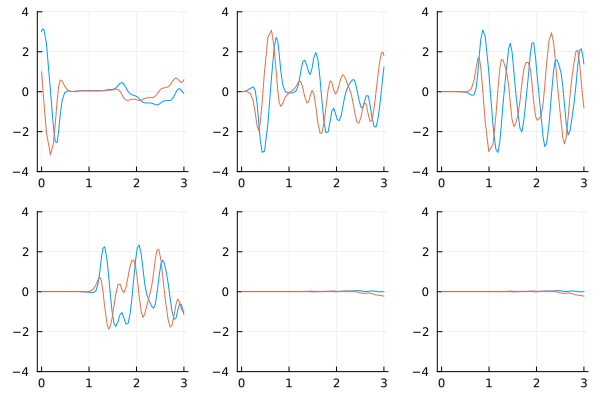

In [42]:
q1=  [u[1] for u in sol1.u]
q2=  [u[2] for u in sol1.u]
q3=  [u[3] for u in sol1.u]
q4=  [u[4] for u in sol1.u]
q5=  [u[5] for u in sol1.u]
p1=  [u[6] for u in sol1.u]
p2=  [u[7] for u in sol1.u]
p3=  [u[8] for u in sol1.u]
p4=  [u[9] for u in sol1.u]
p5=  [u[10] for u in sol1.u]


pl1=plot(sol1.t,q1, label="") 
    plot!(pl1,sol1.t,p1, label="") 
pl2=plot(sol1.t,q2, label="") 
    plot!(pl2,sol1.t,p2, label="") 
pl3=plot(sol1.t,q3, label="") 
    plot!(pl3,sol1.t,p3, label="") 
pl4=plot(sol1.t,q4, label="")
    plot!(pl4,sol1.t,p4, label="") 
pl5=plot(sol1.t,q5, label="") 
    plot!(pl5,sol1.t,p5, label="") 

plot(pl1,pl2,pl3,pl4,pl5,pl5, layout=(2,3),ylims=(-4,4))

### IRKGL16 (constant step size) 

In [59]:
sol3 = solve(prob64,IRKGL16(simd=true), dt=2e-2, adaptive=false)
sol3.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  12568
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     1571
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          150
Number of rejected steps:                          0

In [60]:
@btime solve(prob64,IRKGL16(simd=true), dt=2e-2, adaptive=false, save_everystep=false);

  631.151 μs (237 allocations: 64.25 KiB)


### Vern9 (constant step size) 

In [72]:
sol10 =solve(prob64,Vern9(),dt=4e-3, adaptive=false);
sol10.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  12000
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          750
Number of rejected steps:                          0

In [73]:
@btime solve(prob64,Vern9(), dt=4e-3, adaptive=false, save_everystep=false);

  728.859 μs (12052 allocations: 193.08 KiB)


### Energy Error

In [88]:
setprecision(BigFloat, 256)
u0256 =InitialNLS(BigFloat)

E0=NLSHam(u0256,[])
ΔE1 = map(x->NLSHam(BigFloat.(x),[]), sol1.u)./E0.-1;
ΔE2 = map(x->NLSHam(BigFloat.(x),[]), sol2.u)./E0.-1;
ΔE3 = map(x->NLSHam(BigFloat.(x),[]), sol3.u)./E0.-1;
ΔE9 = map(x->NLSHam(BigFloat.(x),[]), sol9.u)./E0.-1;
ΔE10 = map(x->NLSHam(BigFloat.(x),[]), sol10.u)./E0.-1;
(Float32(maximum(abs.(ΔE1))),Float32(maximum(abs.(ΔE2))),Float32(maximum(abs.(ΔE2))),Float32(maximum(abs.(ΔE9))), Float32(maximum(abs.(ΔE10))))

(7.538828f-15, 8.277248f-15, 8.277248f-15, 4.786334f-15, 7.272946f-15)

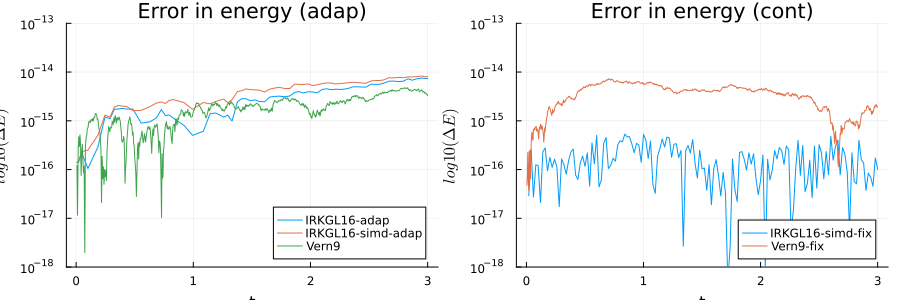

In [89]:
yrange=(1e-18,1e-13)
pl1=plot(title="Error in energy (adap)", xlabel="t", ylabel=L"log10(\Delta E)", 
         legend=:bottomright, ylimits=yrange)
plot!(pl1, sol1.t[2:end], abs.(ΔE1[2:end]), yscale=:log10, label="IRKGL16-adap")
plot!(pl1, sol2.t[2:end], abs.(ΔE2[2:end]), yscale=:log10, label="IRKGL16-simd-adap")
plot!(pl1, sol9.t[2:end], abs.(ΔE9[2:end]), yscale=:log10, label="Vern9")

pl2=plot(title="Error in energy (cont)", xlabel="t", ylabel=L"log10(\Delta E)",
          legend=:bottomright, ylimits=yrange)
plot!(pl2, sol3.t[2:end], abs.(ΔE3[2:end]), yscale=:log10, label="IRKGL16-simd-fix")
plot!(pl2, sol10.t[2:end], abs.(ΔE10[2:end]), yscale=:log10, label="Vern9-fix")

plot(pl1,pl2, layout=(1,2), size=(900,300))

<a href="#top">Back to the top</a>

## Float128 Computations

In [90]:
setprecision(BigFloat, 108);

### IRKGL16 

In [91]:
sol11 = solve(prob128,IRKGL16(),reltol=BigFloat(1e-20), abstol=BigFloat(1e-20), adaptive=true)
sol11.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  34568
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     4321
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          206
Number of rejected steps:                          24

In [93]:
@btime solve(prob128,IRKGL16(),reltol=BigFloat(1e-20), abstol=BigFloat(1e-20), adaptive=true, save_everystep=false);

  727.011 ms (26909796 allocations: 1.10 GiB)


### Vern9 

In [94]:
sol19 =solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20);
sol19.destats

SciMLBase.DEStats
Number of function 1 evaluations:                  39154
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          2446
Number of rejected steps:                          1

In [107]:
@time solve(prob128,Vern9(),abstol=1e-20,reltol=1e-20, save_everystep=false);

  1.553376 seconds (31.06 M allocations: 1.427 GiB, 9.21% gc time)


### Some Plots

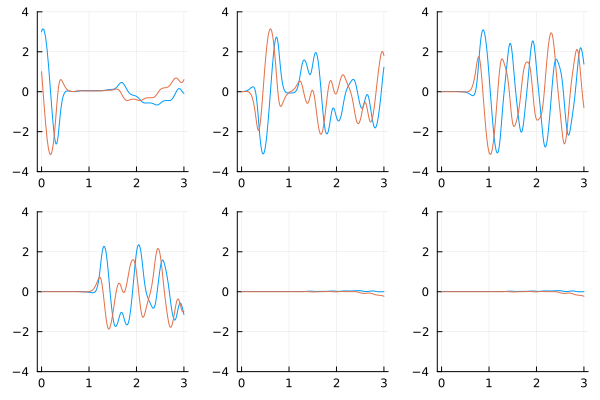

In [99]:
q1=  [u[1] for u in sol11.u]
q2=  [u[2] for u in sol11.u]
q3=  [u[3] for u in sol11.u]
q4=  [u[4] for u in sol11.u]
q5=  [u[5] for u in sol11.u]
p1=  [u[6] for u in sol11.u]
p2=  [u[7] for u in sol11.u]
p3=  [u[8] for u in sol11.u]
p4=  [u[9] for u in sol11.u]
p5=  [u[10] for u in sol11.u]


pl1=plot(sol11.t,q1, label="") 
    plot!(pl1,sol11.t,p1, label="") 
pl2=plot(sol11.t,q2, label="") 
    plot!(pl2,sol11.t,p2, label="") 
pl3=plot(sol11.t,q3, label="") 
    plot!(pl3,sol11.t,p3, label="") 
pl4=plot(sol11.t,q4, label="")
    plot!(pl4,sol11.t,p4, label="") 
pl5=plot(sol11.t,q5, label="") 
    plot!(pl5,sol11.t,p5, label="") 

plot(pl1,pl2,pl3,pl4,pl5,pl5, layout=(2,3),ylims=(-4,4))


<a href="#top">Back to the top</a>

### Error in energy

In [100]:
setprecision(BigFloat, 256)
u0128 =InitialNLS(BigFloat)

E0=NLSHam(u0128,[])

ΔE11 = map(x->NLSHam(BigFloat.(x),[]), sol11.u)./E0.-1
ΔE19 = map(x->NLSHam(BigFloat.(x),[]), sol19.u)./E0.-1
(Float32(maximum(abs.(ΔE11))) ,Float32(maximum(abs.(ΔE19))))

(3.1793723f-23, 5.281192f-22)

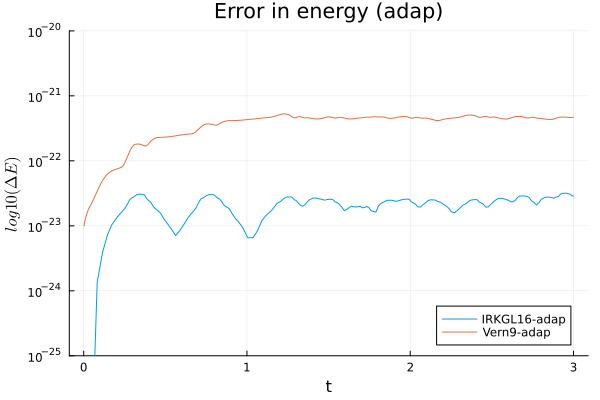

In [102]:
yrange=(1e-25,1e-20)
pl1=plot(title="Error in energy (adap)", xlabel="t", ylabel=L"log10(\Delta E)", 
         legend=:bottomright, ylimits=yrange)
plot!(pl1, sol11.t[2:end], abs.(ΔE11[2:end]), yscale=:log10, label="IRKGL16-adap")
plot!(pl1, sol19.t[2:end], abs.(ΔE19[2:end]), yscale=:log10, label="Vern9-adap")

<a href="#top">Back to the top</a>